In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import pandas as pd
from tqdm import tqdm as tm

from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device

print(device)

cpu


The RGD stuff seems to have 2 stability-ish issues that needs to be addressed:
1. once in a while, it fails to minimize the out-of-simplex loss
2. it is not really affected by the initial guess

In [8]:
N = 20
temp = sim.ABC_Monte_Carlo.consistency_T2(number_of_iterations = N, 
                                          nodes_set = [2100],
                                          beta = [1,1,-4, 5],
                                          alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]],
                                          seeded = True,
                                          constrained = False,
                                          oracle_lat_pos = False,
                                          oracle_align = False,
                                          no_oracle = True)

2100: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


In [9]:
model = sim.ABC(time = 2,
            nodes = 3,
            beta = [1,1,-4, 5],
            alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
C = model.settings.C

res = torch.tensor(temp.MC_result.est["B_est"]).reshape(N, 21).T

torch.linalg.solve(C.T @ C, C.T @ res).T

tensor([[    nan,     nan,     nan,     nan],
        [ 0.9089,  1.0048, -4.1748,  4.0091],
        [ 0.9646,  1.0339, -4.0201,  2.6591],
        [ 0.9278,  1.0110, -4.1325,  3.3824],
        [ 0.9240,  1.0739, -4.0853,  1.6832],
        [ 0.9695,  0.9517, -4.1929,  3.1778],
        [    nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan],
        [    nan,     nan,     nan,     nan],
        [ 1.0172,  0.9728, -4.0101,  3.5798],
        [ 0.9663,  1.0169, -4.0474,  2.5067],
        [    nan,     nan,     nan,     nan],
        [ 0.9363,  1.0194, -4.1493,  3.0929],
        [ 0.9640,  0.9748, -4.1847,  2.3886],
        [ 0.9312,  0.9946, -4.2142,  3.5750],
        [ 1.0355,  0.9262, -4.1089,  3.5312],
        [ 0.9728,  1.0057, -4.0839,  2.7289],
        [ 0.9539,  1.0143, -4.1088,  3.5724],
        [ 0.9666,  0.9423, -4.2055,  3.2914],
        [ 0.9962,  0.9925, -4.0159,  4.2521]])

2 tensor(2.4364) tensor(0.1106)
3 tensor(2.0382) tensor(0.0743)
4 tensor(2.0050) tensor(0.0331)
5 tensor(1.9177) tensor(0.0563)
6 tensor(2.0558) tensor(0.1144)
7 tensor(1.9242) tensor(0.0569)
8 tensor(2.2786) tensor(0.1564)
9 tensor(1.8439) tensor(0.1836)
10 tensor(1.9515) tensor(0.1127)
11 tensor(2.3491) tensor(0.1460)
12 tensor(2.0015) tensor(0.1593)
13 tensor(2.2002) tensor(0.0589)
14 tensor(2.0971) tensor(0.1494)
15 tensor(2.2425) tensor(0.0637)
16 tensor(2.1402) tensor(0.0582)
17 tensor(2.0923) tensor(0.1320)
18 tensor(1.9562) tensor(0.0725)
19 tensor(2.1774) tensor(0.2158)
20 tensor(2.2165) tensor(0.1046)
21 tensor(1.6643) tensor(0.0893)
22 tensor(2.1406) tensor(0.0660)
23 tensor(2.2916) tensor(0.1380)
24 tensor(1.8461) tensor(0.0860)
25 tensor(1.8939) tensor(0.1345)
26 tensor(2.2121) tensor(0.0265)
27 tensor(1.9628) tensor(0.0944)
28 tensor(2.0585) tensor(0.1300)
29 tensor(1.7679) tensor(0.1271)
30 tensor(2.0629) tensor(0.1721)
31 tensor(1.8046) tensor(0.1074)
32 tensor(2.2724) 

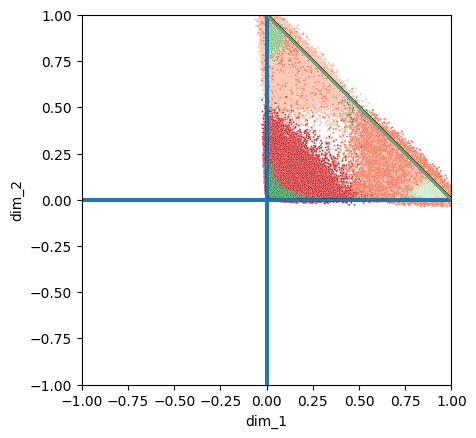

In [4]:
i = 1
while i <= 200:
    model = sim.ABC(time = 2,
            nodes = 3,
            beta = [1,1,-4, 5],
            alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
    p = model.settings.p
    torch.manual_seed(i)
    model.update_settings(nodes = 1200)
    Z0 = model.synth_data["lat_pos"][0,]
    Z1 = model.synth_data["lat_pos"][1,]
    Y0 = model.synth_data["obs_adj"][0,]
    Y1 = model.synth_data["obs_adj"][1,]


    Z0_no_oracle = Align.No_Oracle(Y0, (p-1)).aligned
    vls.lat_vis(df = Z0_no_oracle, 
                K = 3,
                LB = -1, 
                palette = "Reds")

    Z1_no_oracle = Align.No_Oracle(Y1, (p-1)).aligned
    vls.lat_vis(df = Z1_no_oracle, 
                K = 3,
                LB = -1, 
                palette = "Greens")
    i += 1
    print(i, 
        Align.Op_Riemannian_GD.simplex_loss_relu(Z0_no_oracle),
        Align.Op_Riemannian_GD.simplex_loss_relu(Z1_no_oracle))

tensor([[ 0.2883, -0.6349, -1.5894],
        [-0.9015,  0.0746, -1.9512],
        [ 1.0190,  0.0496, -1.1308],
        [ 0.6155,  1.7110, -0.2768],
        [-3.5166,  0.5946,  4.7803],
        [ 1.0174, -2.7246,  5.3492],
        [ 3.1515,  2.9987,  0.9010]])

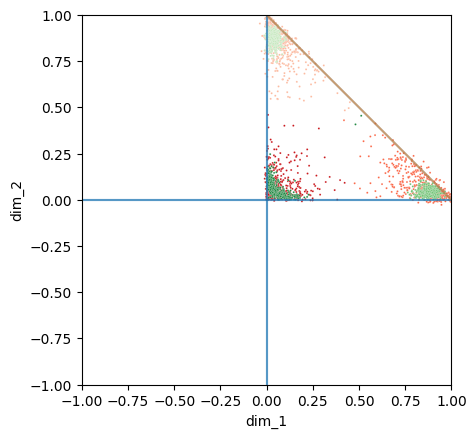

In [80]:
model = sim.ABC(time = 2,
                nodes = 3,
                beta = [1,1,-4, 5],
                alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
p = model.settings.p
# torch.manual_seed(1)
model.update_settings(nodes = 1200)
Z0 = model.synth_data["lat_pos"][0,]
Z1 = model.synth_data["lat_pos"][1,]
Y0 = model.synth_data["obs_adj"][0,]
Y1 = model.synth_data["obs_adj"][1,]


ASE_0 = Align.Oracle.ASE(Y0, (p-1))
ASE_1 = Align.Oracle.ASE(Y1, (p-1))

A_mat_0 = Align.Op_Riemannian_GD(ASE_0, "relu").align_mat
A_mat_1 = Align.Op_Riemannian_GD(ASE_1, "softplus", softplus_parameter= 5).align_mat

aligned_0 = ASE_0 @ A_mat_0
aligned_1 = ASE_1 @ A_mat_1

vls.lat_vis(df = aligned_0, K = 3, LB = -1, palette= "Reds")
vls.lat_vis(df = aligned_1, K = 3, LB = -1, palette= "Greens")

last_dim_0 = (1 - aligned_0.sum(dim = 1)).unsqueeze(dim = 1)
aligned_0_full = torch.cat([aligned_0, last_dim_0], dim = 1)
X_aligned = sim.ABC.gen_X(Y0, aligned_0_full, 3)

last_dim_1 = (1 - aligned_1.sum(dim = 1)).unsqueeze(dim = 1)
aligned_1_full = torch.cat([aligned_1, last_dim_1], dim = 1)


test = Dir_Reg.fit(X_aligned, aligned_1_full)
test.est_result["estimate"]


In [77]:
model.settings.B @ model.settings.B.T

tensor([[ 2.,  1.,  2.,  1., -8., -4.,  2.],
        [ 1.,  2.,  1.,  2., -4., -8.,  2.],
        [ 2.,  1.,  2.,  1., -8., -4.,  2.],
        [ 1.,  2.,  1.,  2., -4., -8.,  2.],
        [-8., -4., -8., -4., 32., 16., -8.],
        [-4., -8., -4., -8., 16., 32., -8.],
        [ 2.,  2.,  2.,  2., -8., -8., 59.]])

In [79]:
model.settings.B


tensor([[ 1.,  0., -1.],
        [ 0.,  1., -1.],
        [ 1.,  0., -1.],
        [ 0.,  1., -1.],
        [-4.,  0.,  4.],
        [ 0., -4.,  4.],
        [ 5.,  5.,  3.]])

tensor([[ 0.8854,  0.0637,  0.0508],
        [ 0.4663,  0.5376, -0.0039],
        [ 0.8852,  0.0053,  0.1095],
        ...,
        [ 0.0130,  0.1952,  0.7918],
        [ 0.0851,  0.0284,  0.8865],
        [ 0.0278,  0.0523,  0.9199]])